In [59]:
import random
import glob
from multiprocessing import Pool

import skimage.io
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

MERGIN=100
FIX=50

In [60]:
IMAGE_WIDTH=MERGIN * 2 + FIX

In [61]:
def RandomCrop(mat, width, height):    
    img_height = mat.shape[0]
    img_width  = mat.shape[1]

    max_height = img_height - height
    max_width  = img_width - width
    
    r = random.randint(0, max_height)
    c = random.randint(0, max_width)
    
    return mat[r:r+height, c:c+width]

def CropToCenter(mat, width, height):
    img_height = mat.shape[0]
    img_width  = mat.shape[1]
    r = (img_height - height) // 2
    c = (img_width - width) // 2
    return mat[r:r+height, c:c+width]

def RemoveCenterAndFlatten(mat, width, height):
    mask = np.zeros(mat.shape[:-1])
    mask.fill(1.)
    img_height = mat.shape[0]
    img_width  = mat.shape[1]
    r = (img_height - height) // 2
    c = (img_width - width) // 2
    mask[r:r+height, c:c+width] = -1.
    
    return np.reshape(mat[mask >= 0], (-1, mat.shape[-1]))

(50, 50, 3)


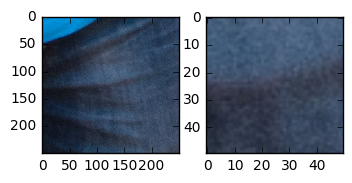

In [62]:
mat = skimage.io.imread('data/fixer_source/_DSC3018.jpg')
mat = RandomCrop(mat, IMAGE_WIDTH, IMAGE_WIDTH)
center_mat = CropToCenter(mat, FIX, FIX)
print(center_mat.shape)
# d, arr = plt.subplots(2)
plt.subplot(131).imshow(mat)
plt.subplot(132).imshow(center_mat)

In [63]:
vector = RemoveCenterAndFlatten(mat, FIX, FIX)
print(vector.shape)

(60000, 3)


In [67]:
def GenerateTrainingSetFrom(fn, img_width, fix_width):
    mat = skimage.io.imread(fn)
    mat = RandomCrop(mat, img_width, img_width)
    result = CropToCenter(mat, fix_width, fix_width)
    result = np.reshape(result, (-1, result.shape[-1]))
    train = RemoveCenterAndFlatten(mat, fix_width, fix_width)
    return train, result

In [72]:
cnt = 0

trainings = []
results = []
SAMPLE_LIMIT = 1000

def GenerateTrainingSetFromWrapper(args):
    return GenerateTrainingSetFrom(*args)

with Pool(8) as p:
    for training, result in p.imap_unordered(GenerateTrainingSetFromWrapper,
                                             map(lambda n: (n, IMAGE_WIDTH, FIX),
                                                 glob.glob("data/fixer_source/*"))):
        trainings.append(np.reshape(training, (-1,)))
        results.append(np.reshape(result, (-1,)))
        cnt += 1
        if cnt % 50 == 0:
            print(cnt)
        if cnt >= SAMPLE_LIMIT:
            break

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [71]:
np.savez_compressed("fixer_train.npz",
                    trainings=np.array(trainings),
                    results=np.array(results, dtype=np.double))